# Exploratory Data Analysis (EDA) on USDA HPAI Detections in Wild Birds

## Introduction

### Purpose of the Notebook
To perform an Exploratory Data Analysis (EDA) on the Highly Pathogenic Avian Influenza (HPAI) detections in wild birds. The goal of this analysis is to:
- Understand the structure and contents of the dataset.
- Identify missing values, duplicates, and any inconsistencies.
- Perform data cleaning and preparation for further analysis.
- Visualize trends related to HPAI detections over time, species, and locations.

###  Data Source
The dataset is from the USDA and can be accessed at:
[Detections of Highly Pathogenic Avian Influenza in Wild Birds](https://www.aphis.usda.gov/livestock-poultry-disease/avian/avian-influenza/hpai-detections/wild-birds). The data is stored in a CSV file that was pulled March 4, 2025.


### Data Quality & Cleaning
- No duplicates were removed.
- Why? Each row represents a unique detection, and multiple birds can be detected at the same location on the same day.
- Removing duplicates could lead to data loss, so all detections are preserved.

### Process Overview
1. Load the dataset into pandas.
2. Display basic information about the dataset.
3. Identify missing values.
4. Perform exploratory visualizations to gain insights.

### Access the dataset at the url listed below:
[Detections of Highly Pathogenic Avian Influenza in Wild Birds](https://www.aphis.usda.gov/livestock-poultry-disease/avian/avian-influenza/hpai-detections/wild-birds)
- Scroll, click the csv button provided and download the csv.

In [58]:
## Load the Data

import pandas as pd

# Save csv as: usda_wild_bird_avian_influenza_detections.csv
flu_data = pd.read_csv('usda_wild_bird_avian_influenza_detections.csv')

# Display first few rows of the dataset
flu_data.head()

,State,County,Collection Date,Date Detected,HPAI Strain,Bird Species,WOAH Classification,Sampling Method,Submitting Agency
0,West Virginia,Monongalia,2/18/2025,2/27/2025,EA H5N1,Canada goose,Wild bird,Morbidity/Mortality,NWDP
1,West Virginia,Monongalia,2/18/2025,2/27/2025,EA H5N1,Canada goose,Wild bird,Morbidity/Mortality,NWDP
2,Massachusetts,Worcester,2/18/2025,2/27/2025,EA H5,Mallard,Wild bird,Live bird,NWDP
3,Texas,Bexar,2/13/2025,2/27/2025,EA H5,Black vulture,Wild bird,Morbidity/Mortality,NWDP
4,Texas,Bexar,2/13/2025,2/27/2025,EA H5,Black vulture,Wild bird,Morbidity/Mortality,NWDP


In [59]:
# Check data types and counts
flu_data.info()

# Summary statistics
flu_data.describe(include="all")

# Check for missing values
flu_data.isnull().sum()

# Inspect column names
print(flu_data.columns)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12524 entries, 0 to 12523
Data columns (total 9 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   State                12467 non-null  object
 1   County               12467 non-null  object
 2   Collection Date      12277 non-null  object
 3   Date Detected        12467 non-null  object
 4   HPAI Strain          12466 non-null  object
 5   Bird Species         12467 non-null  object
 6   WOAH Classification  12467 non-null  object
 7   Sampling Method      12467 non-null  object
 8   Submitting Agency    12467 non-null  object
dtypes: object(9)
memory usage: 880.7+ KB
Index(['State', 'County', 'Collection Date', 'Date Detected', 'HPAI Strain',
       'Bird Species', 'WOAH Classification', 'Sampling Method',
       'Submitting Agency'],
      dtype='object')


In [60]:
# Standardize column names: lowercase, replace spaces with underscores
flu_data.columns = (
    flu_data.columns
    .str.strip()           # Remove leading/trailing spaces
    .str.lower()           # Convert to lowercase
    .str.replace(' ', '_') # Replace spaces with underscores
    .str.replace('(', '')  # Remove parentheses
    .str.replace(')', '')  # Remove parentheses
)

# Check updated column names
print(flu_data.columns)

Index(['state', 'county', 'collection_date', 'date_detected', 'hpai_strain',
       'bird_species', 'woah_classification', 'sampling_method',
       'submitting_agency'],
      dtype='object')


In [61]:
# Convert 'collection_date' and 'date_detected' to datetime format
flu_data['collection_date'] = pd.to_datetime(flu_data['collection_date'], errors='coerce')
flu_data['date_detected'] = pd.to_datetime(flu_data['date_detected'], errors='coerce')

# Confirm changes
flu_data.dtypes


state                          object
county                         object
collection_date        datetime64[ns]
date_detected          datetime64[ns]
hpai_strain                    object
bird_species                   object
woah_classification            object
sampling_method                object
submitting_agency              object
dtype: object

In [62]:
# Check for missing values
print(flu_data.isnull().sum())

# Fill missing values in 'hpai_strain' with 'Unknown'
if 'hpai_strain' in flu_data.columns:
    flu_data['hpai_strain'] = flu_data['hpai_strain'].fillna('Unknown')

# Fill other missing values if needed
flu_data = flu_data.fillna("Unknown")

# Check missing values are corrected
print(flu_data.isnull().sum())


state                   57
county                  57
collection_date        247
date_detected           57
hpai_strain             58
bird_species            57
woah_classification     57
sampling_method         57
submitting_agency       57
dtype: int64
state                  0
county                 0
collection_date        0
date_detected          0
hpai_strain            0
bird_species           0
woah_classification    0
sampling_method        0
submitting_agency      0
dtype: int64


In [63]:
# Did not remove duplicates
print("No duplicates were removed because each row represents a valid detection.")

No duplicates were removed because each row represents a valid detection.


In [64]:
# File path to cleaned dataset
cleaned_file_path = "cleaned_usda_hpai_wildbirds.csv"  

# Save cleaned dataset as CSV
flu_data.to_csv(cleaned_file_path, index=False)


In [72]:
print(f"Cleaned dataset saved as {cleaned_file_path}")

Cleaned dataset saved as cleaned_usda_hpai_wildbirds.csv


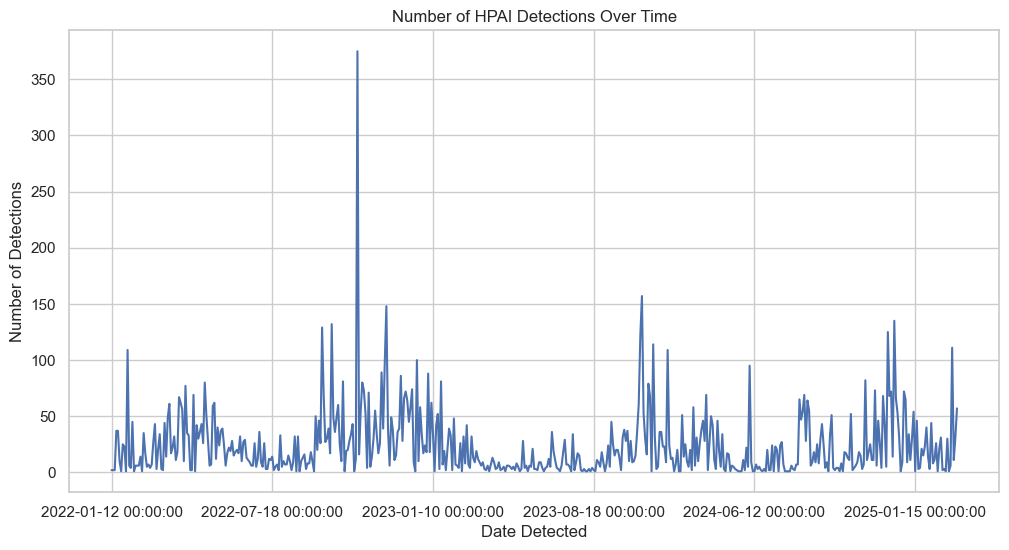

In [69]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set plot style
sns.set(style="whitegrid")

# Plot the number of detections over time
plt.figure(figsize=(12, 6))
flu_data.groupby('date_detected').size().plot()
plt.title("Number of HPAI Detections Over Time")
plt.xlabel("Date Detected")
plt.ylabel("Number of Detections")
plt.show()


c:\Users\hxa6\AppData\Local\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 128197 (\N{CALENDAR}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


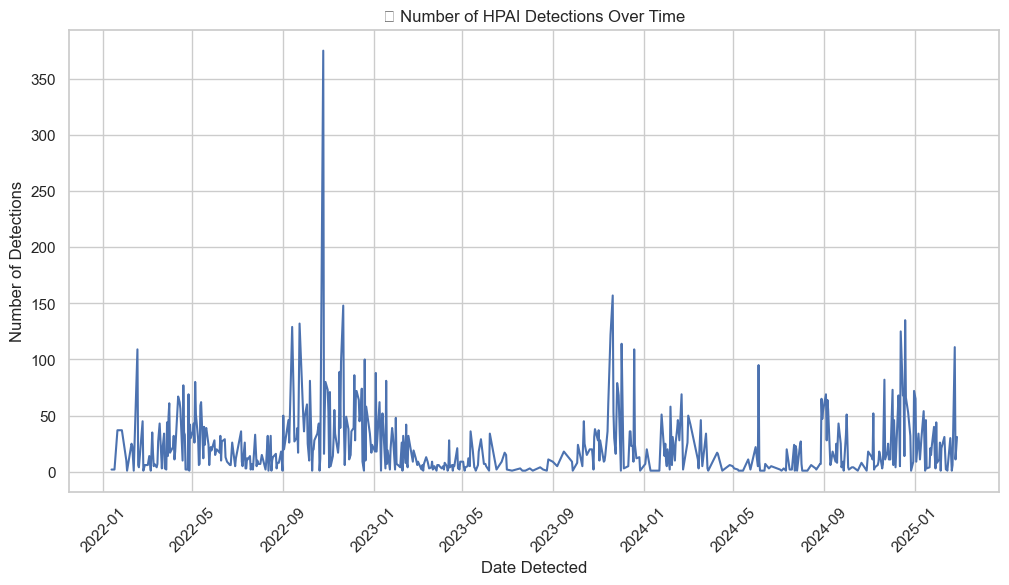

In [80]:
# Ensure 'date_detected' is in datetime format, setting errors='coerce' to handle non-date values
flu_data['date_detected'] = pd.to_datetime(flu_data['date_detected'], errors='coerce')

# Drop rows where 'date_detected' is still NaT (not a date)
flu_data = flu_data.dropna(subset=['date_detected'])

import matplotlib.dates as mdates
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(12,6))

# Group by date and count occurrences
daily_trends = flu_data.groupby('date_detected').size().reset_index(name='detections')

sns.lineplot(data=daily_trends, x='date_detected', y='detections')

plt.title("Number of HPAI Detections Over Time")
plt.xlabel("Date Detected")
plt.ylabel("Number of Detections")

# ✅ Format x-axis labels to show only year and month
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))  # Format as YYYY-MM
plt.xticks(rotation=45)  # Rotate for better readability
plt.grid(True)

plt.show()


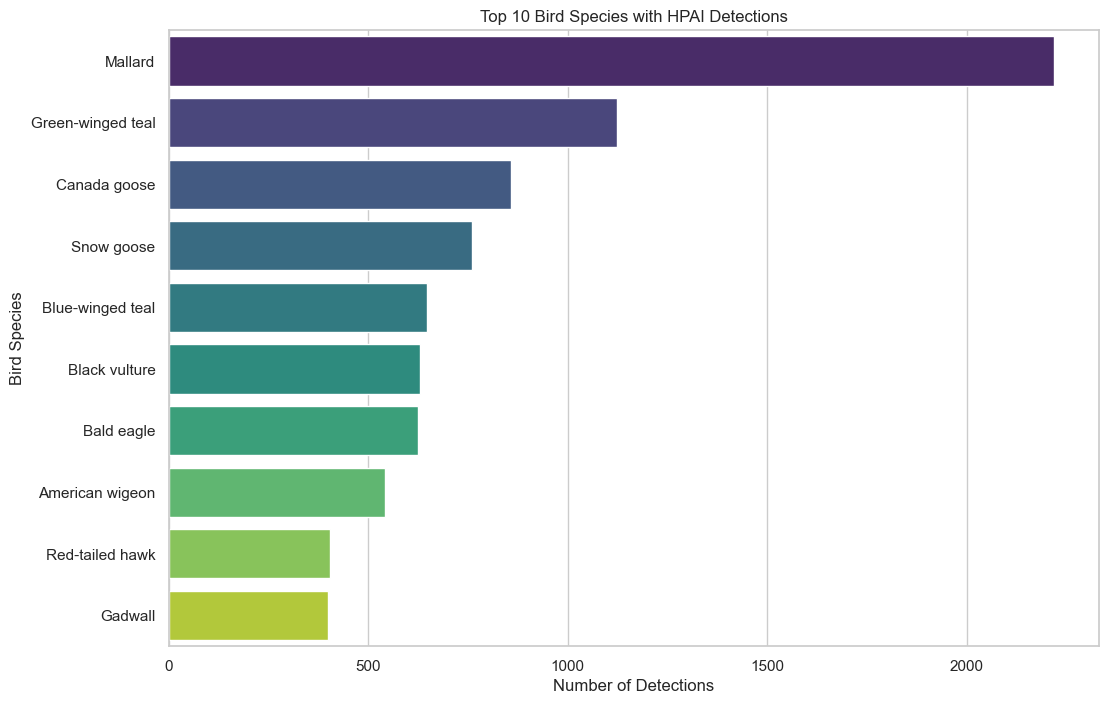

In [76]:
import matplotlib.pyplot as plt
import seaborn as sns

# Bar plot of detections by bird species
plt.figure(figsize=(12, 8))

# Use the correct column name
species_counts = flu_data['bird_species'].value_counts().head(10)  # Top 10 species

sns.barplot(y=species_counts.index, x=species_counts.values, palette="viridis")
plt.title("Top 10 Bird Species with HPAI Detections")
plt.xlabel("Number of Detections")
plt.ylabel("Bird Species")
plt.show()


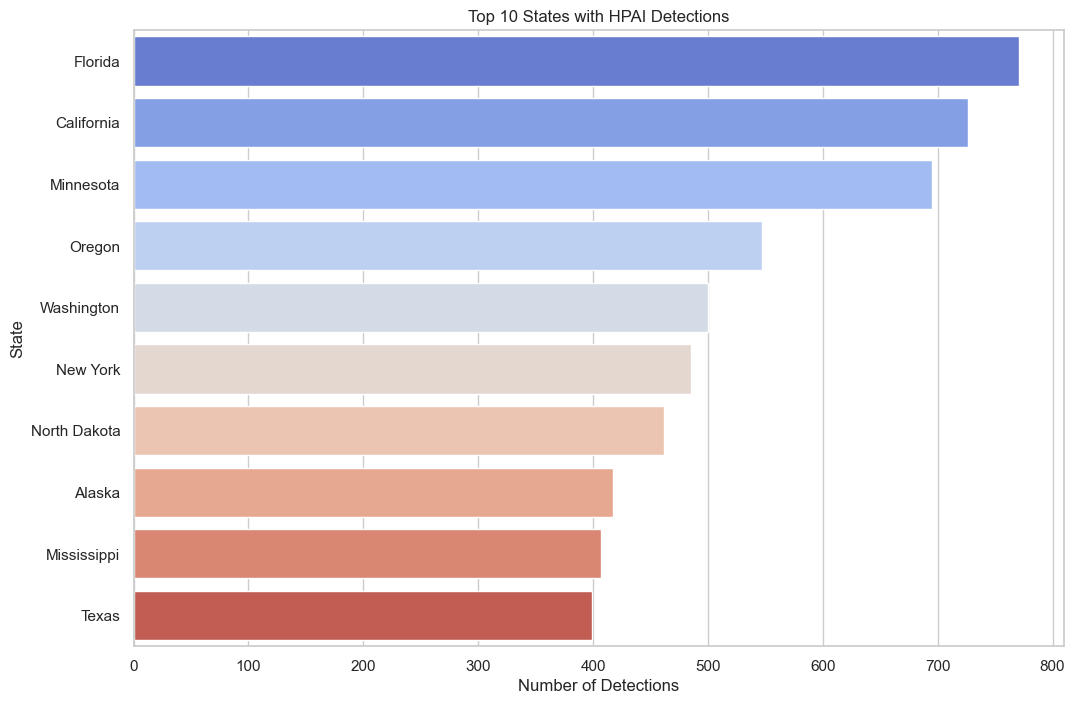

In [77]:
# Bar plot of detections by state
plt.figure(figsize=(12, 8))
state_counts = flu_data['state'].value_counts().head(10)  # Top 10 states
sns.barplot(y=state_counts.index, x=state_counts.values, palette="coolwarm")
plt.title("Top 10 States with HPAI Detections")
plt.xlabel("Number of Detections")
plt.ylabel("State")
plt.show()
